In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Small dataset of short sentences
sentences = [
    "the cat sat on the mat",
    "the dog chased the cat",
    "a small cat drank milk",
    "dogs and cats are friends",
    "the mat was on the floor",
    "the big dog sat quietly",
    "a cat and a dog played",
    "milk was on the table",
    "the small dog barked loudly",
    "cats drank milk on the mat"
]

# Tokenize
tokenized = [s.lower().split() for s in sentences]
tokenized


[['the', 'cat', 'sat', 'on', 'the', 'mat'],
 ['the', 'dog', 'chased', 'the', 'cat'],
 ['a', 'small', 'cat', 'drank', 'milk'],
 ['dogs', 'and', 'cats', 'are', 'friends'],
 ['the', 'mat', 'was', 'on', 'the', 'floor'],
 ['the', 'big', 'dog', 'sat', 'quietly'],
 ['a', 'cat', 'and', 'a', 'dog', 'played'],
 ['milk', 'was', 'on', 'the', 'table'],
 ['the', 'small', 'dog', 'barked', 'loudly'],
 ['cats', 'drank', 'milk', 'on', 'the', 'mat']]

In [5]:
# Build vocabulary
vocab = {"[PAD]": 0}
for sent in tokenized:
    for tok in sent:
        if tok not in vocab:
            vocab[tok] = len(vocab)

id2tok = {i: t for t, i in vocab.items()}

# Encode sentences with padding
max_len = max(len(s) for s in tokenized)

def encode(tokens):
    ids = [vocab[t] for t in tokens]
    if len(ids) < max_len:
        ids += [vocab["[PAD]"]] * (max_len - len(ids))
    return ids

input_ids = np.array([encode(s) for s in tokenized], dtype=np.int32)

print("Vocabulary:", vocab)
print("\nInput token IDs:\n", input_ids)


Vocabulary: {'[PAD]': 0, 'the': 1, 'cat': 2, 'sat': 3, 'on': 4, 'mat': 5, 'dog': 6, 'chased': 7, 'a': 8, 'small': 9, 'drank': 10, 'milk': 11, 'dogs': 12, 'and': 13, 'cats': 14, 'are': 15, 'friends': 16, 'was': 17, 'floor': 18, 'big': 19, 'quietly': 20, 'played': 21, 'table': 22, 'barked': 23, 'loudly': 24}

Input token IDs:
 [[ 1  2  3  4  1  5]
 [ 1  6  7  1  2  0]
 [ 8  9  2 10 11  0]
 [12 13 14 15 16  0]
 [ 1  5 17  4  1 18]
 [ 1 19  6  3 20  0]
 [ 8  2 13  8  6 21]
 [11 17  4  1 22  0]
 [ 1  9  6 23 24  0]
 [14 10 11  4  1  5]]


In [7]:
# Embedding dimension
d_model = 16

# Random embeddings
np.random.seed(42)
embedding_matrix = np.random.randn(len(vocab), d_model) / np.sqrt(d_model)

# Lookup embeddings
emb = embedding_matrix[input_ids]  # shape: (B, L, d_model)

# Sinusoidal positional encoding
def positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, None]
    i = np.arange(d_model)[None, :]
    angle_rates = 1 / np.power(10000, (2*(i//2)) / d_model)
    angles = pos * angle_rates

    pe = np.zeros_like(angles)
    pe[:, 0::2] = np.sin(angles[:, 0::2])
    pe[:, 1::2] = np.cos(angles[:, 1::2])
    return pe

pos_enc = positional_encoding(max_len, d_model)
x = emb + pos_enc


In [9]:
pad_id = vocab["[PAD]"]
mask = (input_ids != pad_id).astype(np.float32)   # (B, L)


In [11]:
def layer_norm(x, eps=1e-5):
    mean = x.mean(-1, keepdims=True)
    var = np.mean((x - mean)**2, axis=-1, keepdims=True)
    return (x - mean) / np.sqrt(var + eps)


In [13]:
def multi_head_self_attention(x, mask, num_heads=2):
    B, L, D = x.shape
    d_head = D // num_heads

    # Q = K = V = x (no learned projections for simplicity)
    q = x.reshape(B, L, num_heads, d_head).transpose(0,2,1,3)
    k = q
    v = q

    # Attention scores
    scores = np.matmul(q, k.transpose(0,1,3,2)) / np.sqrt(d_head)

    # Apply mask (pad positions = very negative)
    mask_expanded = mask[:, None, None, :]
    scores = np.where(mask_expanded == 1, scores, -1e9)

    # Softmax
    scores_exp = np.exp(scores - scores.max(axis=-1, keepdims=True))
    attn = scores_exp / scores_exp.sum(axis=-1, keepdims=True)

    # Output
    out = np.matmul(attn, v)
    out = out.transpose(0,2,1,3).reshape(B, L, D)
    return out, attn


In [15]:
def feed_forward(x, d_ff=64):
    B, L, D = x.shape
    W1 = np.random.randn(D, d_ff) / np.sqrt(D)
    W2 = np.random.randn(d_ff, D) / np.sqrt(d_ff)

    h = np.maximum(0, x @ W1)  # ReLU
    out = h @ W2
    return out


In [17]:
def transformer_encoder(x, mask, num_heads=2):
    # Multi-head attention + Add & Norm
    attn_out, attn_w = multi_head_self_attention(x, mask, num_heads)
    x = layer_norm(x + attn_out)

    # Feed-forward + Add & Norm
    ff_out = feed_forward(x)
    x = layer_norm(x + ff_out)

    return x, attn_w

contextual_embeddings, attn_weights = transformer_encoder(x, mask, num_heads=2)


In [19]:
# Show embeddings for first sentence (non-pad words)
first_sentence_len = (input_ids[0] != pad_id).sum()
tokens = [id2tok[i] for i in input_ids[0][:first_sentence_len]]

print("Tokens:", tokens)
print("\nContextual embeddings:\n")
print(contextual_embeddings[0, :first_sentence_len])


Tokens: ['the', 'cat', 'sat', 'on', 'the', 'mat']

Contextual embeddings:

[[-0.82053435  1.22742924 -0.41063066 -0.24221071 -0.03759848  0.82933313
  -0.19702625  0.50625206 -1.46809115  1.53859242 -1.94387893  1.08715008
  -0.80331274  0.51723864 -0.93751834  1.15480605]
 [-0.02868432  0.51738499  0.06606334 -0.58849422 -0.48926969  0.90644298
  -0.71236367  0.79582919 -1.01574106  1.11630143 -1.75953195  1.34953871
  -1.34614037  0.73198463 -1.10050354  1.55718354]
 [-0.05318488 -0.5194629   0.12387961 -0.8829708  -0.36226847  1.65763803
  -0.16645042  0.95452153 -1.20087747  1.06369109 -1.45584472  1.68662917
  -1.19226367  0.51904491 -1.05325078  0.88116978]
 [-0.3676257  -0.44935278  0.1547101  -0.82749373 -0.09475602  1.19909715
  -0.14780539  1.01293025 -0.89489404  1.64446886 -2.05557136  1.52618806
  -1.15776537  0.42603787 -0.64639296  0.67822506]
 [-1.2873013  -0.00457314  0.09682767 -0.69272809  0.5033407   0.75880331
   0.00714054  0.89789857 -1.41438638  1.63222088 -1.57

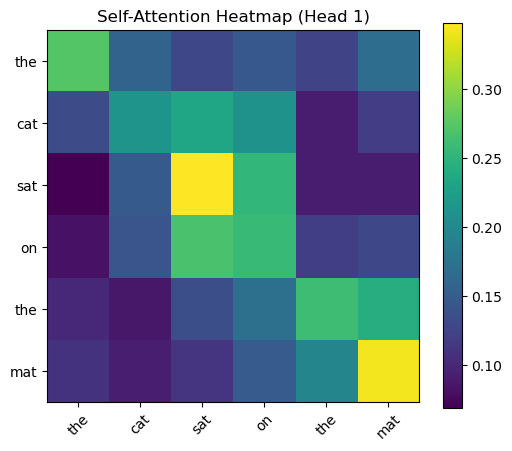

In [21]:
# Select head 1 for sentence 1
A = attn_weights[0, 0]   # shape: (L, L)
A = A[:first_sentence_len, :first_sentence_len]

plt.figure(figsize=(6,5))
plt.imshow(A, cmap="viridis")
plt.xticks(range(first_sentence_len), tokens, rotation=45)
plt.yticks(range(first_sentence_len), tokens)
plt.title("Self-Attention Heatmap (Head 1)")
plt.colorbar()
plt.show()
